<a href="https://colab.research.google.com/github/vahadruya/Capstone-Project-Unsupervised-ML-Topic-Modelling/blob/main/Trial%20Notebooks/Classification_ML_Capstone_CVD_Risk_Prediction_dropna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project**    - Cardiovascular Risk Prediction



##### **Project Type**    - Classification
##### **Contribution**    - Individual
##### **Team Member -** Aditya A P

### **Day 1** - In this notebook, all missing values of the relevant columns are dropped instead of imputing them intelligently, to avoid hampering with patient data. The results are then stored in a csv file and compared with the original for comparison

## **1. Know Your Data**

### Import Libraries

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_1samp, shapiro
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import recall_score, make_scorer, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG, display

import warnings
warnings.filterwarnings('ignore')

### Dataset Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Dataset
path = '/content/drive/MyDrive/ALMA BETTER/Module 4/#CAPSTONE 2 - CLASSIFICATION/Input/data_cardiovascular_risk.csv'
df = pd.read_csv(path)

## **2. Understanding Your Variables**

In [ ]:
# Dataset Columns
df.columns

Index(['id', 'age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [ ]:
# Splitting the categorical and continuous variables
categ_vars = ['sex', 'education', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
cont_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

## **3. Feature Engineering & Data Pre-processing**

In [ ]:
# Creating a copy of the data
data = df.copy()

### 1. Handling Missing Values

In [ ]:
data = data.drop('education', axis = 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(8), int64(6), object(2)
memory usage: 423.9+ KB


In [ ]:
data.dropna(inplace = True)

In [ ]:
categ_vars.remove('education')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3004 entries, 1 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3004 non-null   int64  
 1   age              3004 non-null   int64  
 2   sex              3004 non-null   object 
 3   is_smoking       3004 non-null   object 
 4   cigsPerDay       3004 non-null   float64
 5   BPMeds           3004 non-null   float64
 6   prevalentStroke  3004 non-null   int64  
 7   prevalentHyp     3004 non-null   int64  
 8   diabetes         3004 non-null   int64  
 9   totChol          3004 non-null   float64
 10  sysBP            3004 non-null   float64
 11  diaBP            3004 non-null   float64
 12  BMI              3004 non-null   float64
 13  heartRate        3004 non-null   float64
 14  glucose          3004 non-null   float64
 15  TenYearCHD       3004 non-null   int64  
dtypes: float64(8), int64(6), object(2)
memory usage: 399.0+ KB


In [ ]:
# Checking for any missing values in the dataset
data.isna().sum()

id                 0
age                0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

### 2. Feature Manipulation and Selection

Before analysing outliers, certain features need to be handled to reduce dimensionality and/or improve multicollinearity. In this section, the redundant variables are removed and features with high correlation (like **sysBP-diaBP** and **diabetes-glucose** as shown below) are dealt with

In [ ]:
data = data.drop(['is_smoking', 'prevalentStroke'], axis = 1)

In [ ]:
data['MAP'] = (data['sysBP'] + 2*data['diaBP'])/3

In [ ]:
# Defining the function for Diabetes grades
def diabetes_grades(df):
  if df['glucose'] >= 126:
    return 4 #Diabetes
  elif df['glucose'] > 100:
    return 3 #Pre-diabetes
  elif df['glucose'] > 70:
    return 2 #Normal
  elif df['glucose'] < 71:
    return 1 #Hypoglycemia

In [ ]:
data['diabetes_grade'] = data.apply(diabetes_grades, axis = 1)

In [ ]:
# Dropping the redundant columns
data = data.drop(['sysBP', 'diaBP', 'glucose', 'diabetes', 'prevalentHyp'], axis = 1)
cont_vars = [var for var in cont_vars if var not in ['sysBP', 'diaBP', 'glucose']]
cont_vars+=['MAP']
categ_vars = [var for var in categ_vars if var not in ['is_smoking', 'diabetes', 'prevalentStroke', 'prevalentHyp']]
categ_vars+=['diabetes_grade']

print(f'The categorical variables are: {categ_vars}')
print(f'The continuous variables are: {cont_vars}')

The categorical variables are: ['sex', 'BPMeds', 'diabetes_grade']
The continuous variables are: ['age', 'cigsPerDay', 'totChol', 'BMI', 'heartRate', 'MAP']


### 3. Handling Outliers

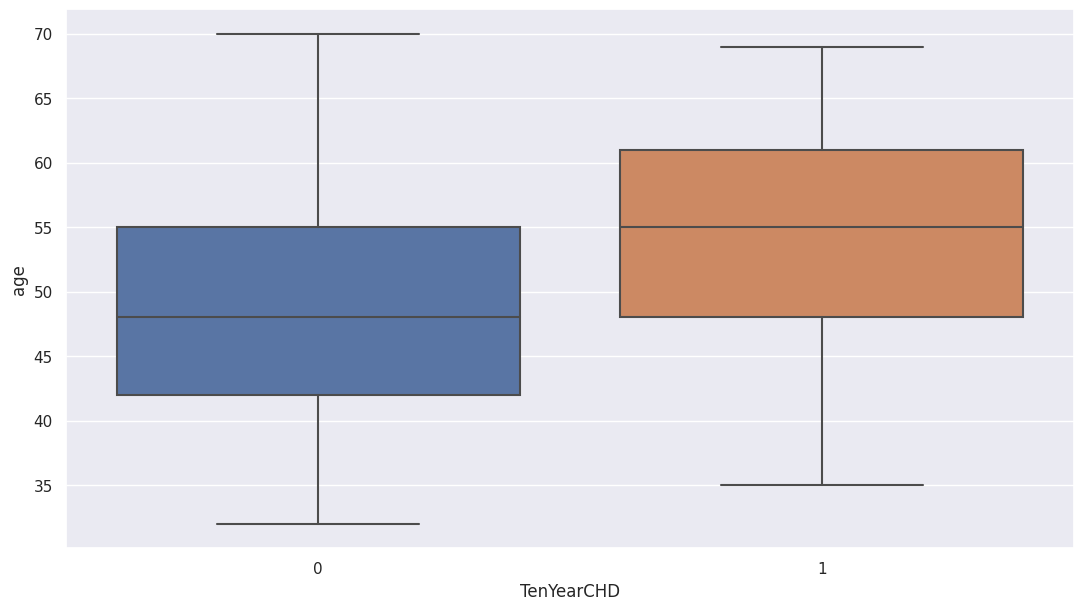

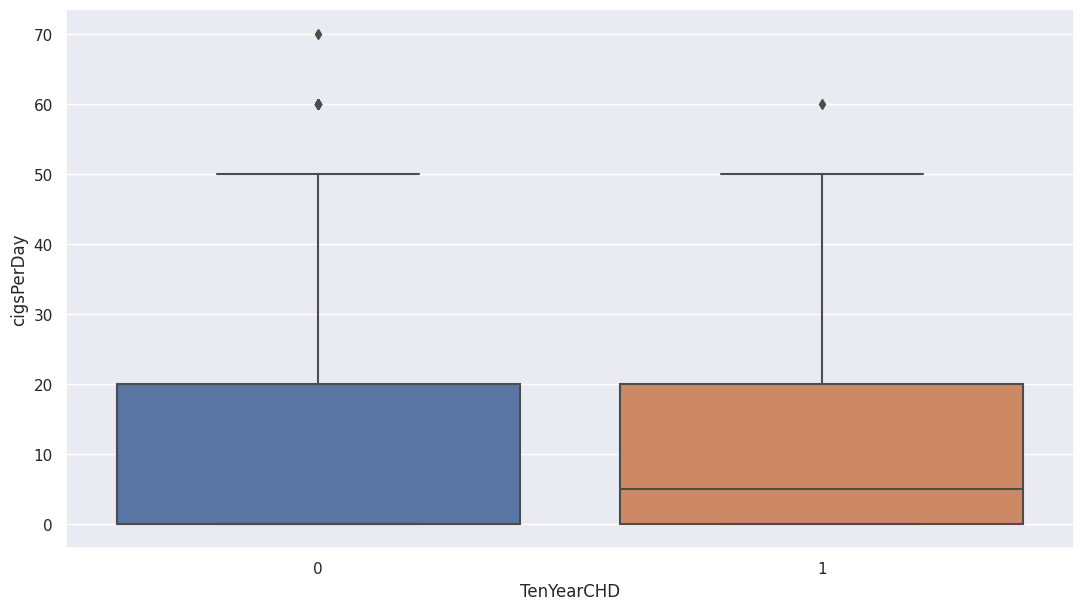

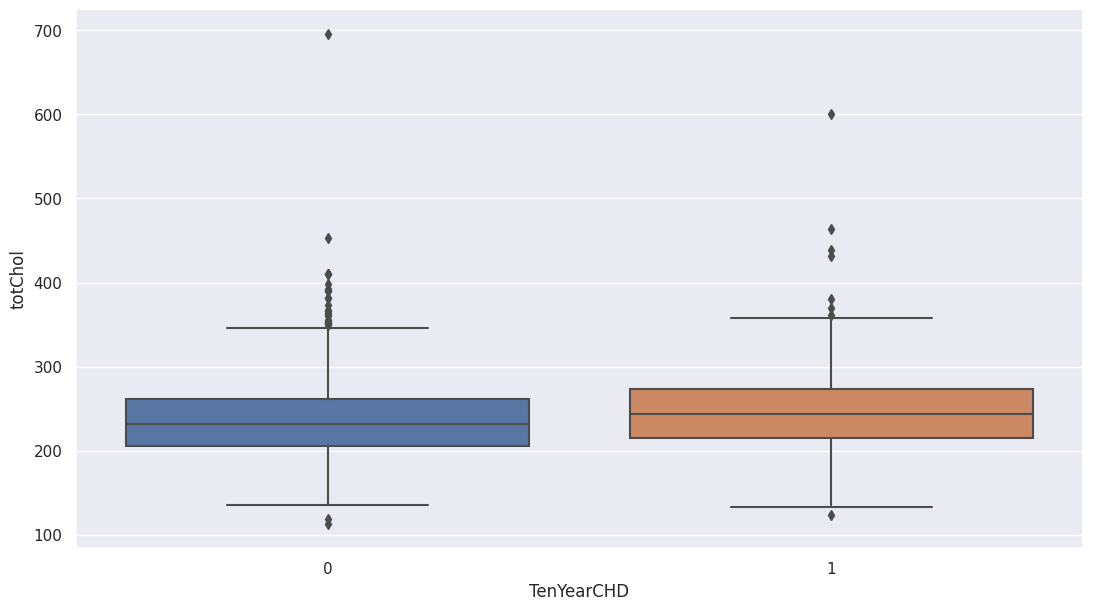

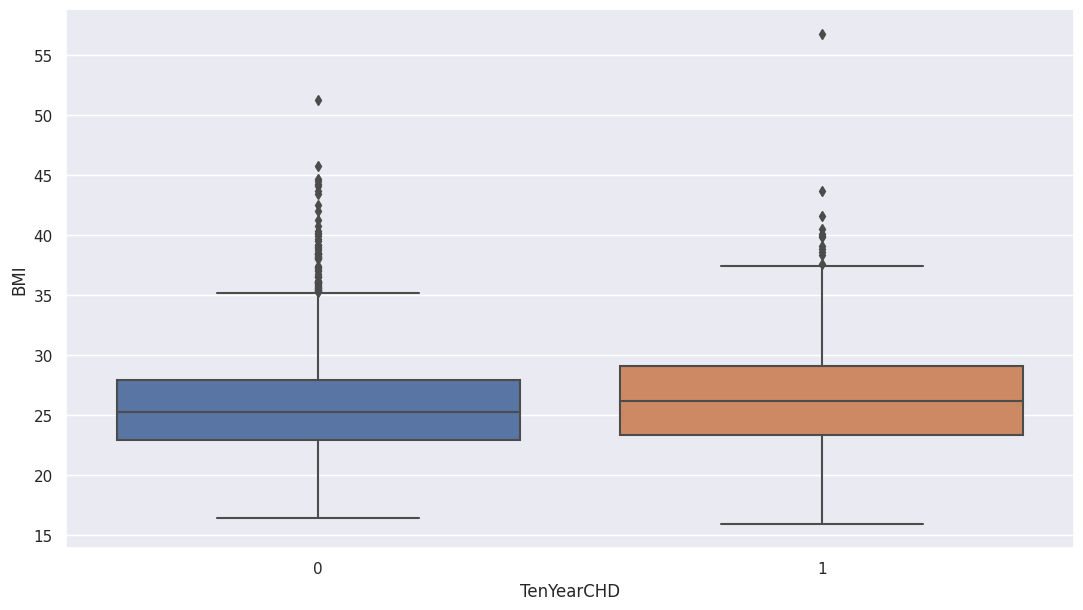

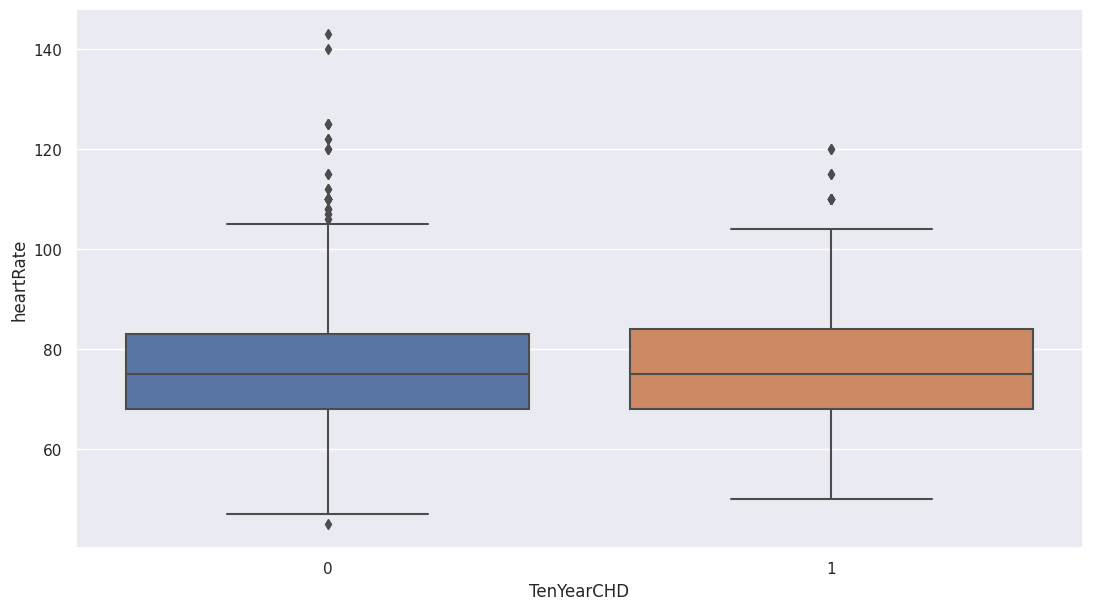

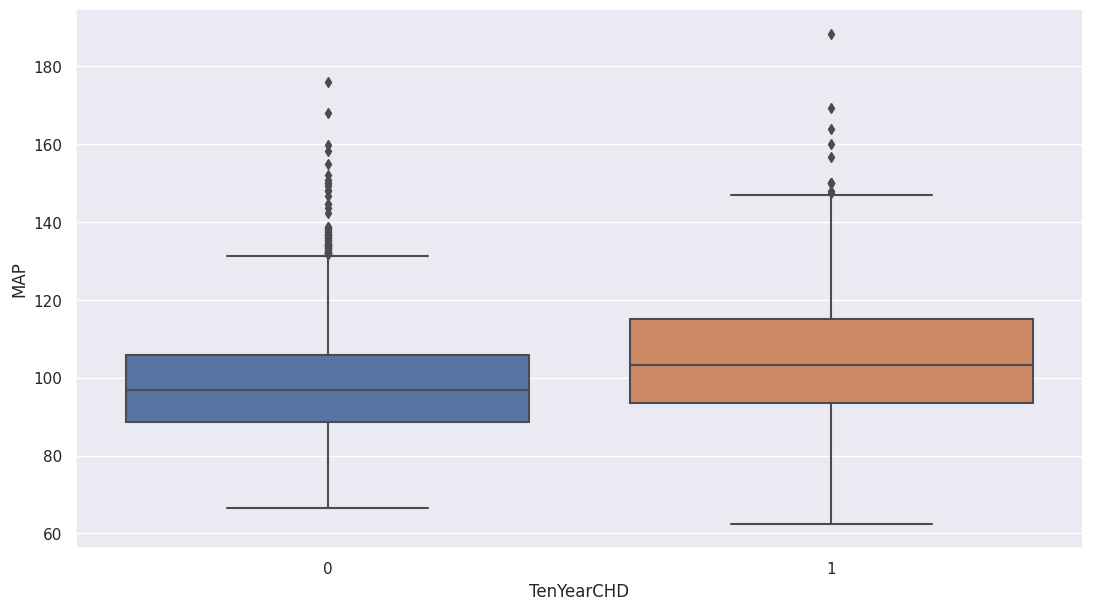

In [ ]:
# Visualising the outliers
sns.set()
for var in cont_vars:
  plt.figure(figsize = (13,7))
  sns.boxplot(data = data, y = var, x = 'TenYearCHD')
  plt.ylabel(var)
  plt.show()

In [ ]:
# Limitting maximum values
max_limits = [50, 500, 45, 120, 165]
outlier_vars = cont_vars[1:]
for var, limit in zip(outlier_vars, max_limits):
  data.loc[data[var] > limit, var] = limit

# Limitting the minimum value of heartRate
data.loc[data['heartRate'] < 50, 'heartRate'] = 50

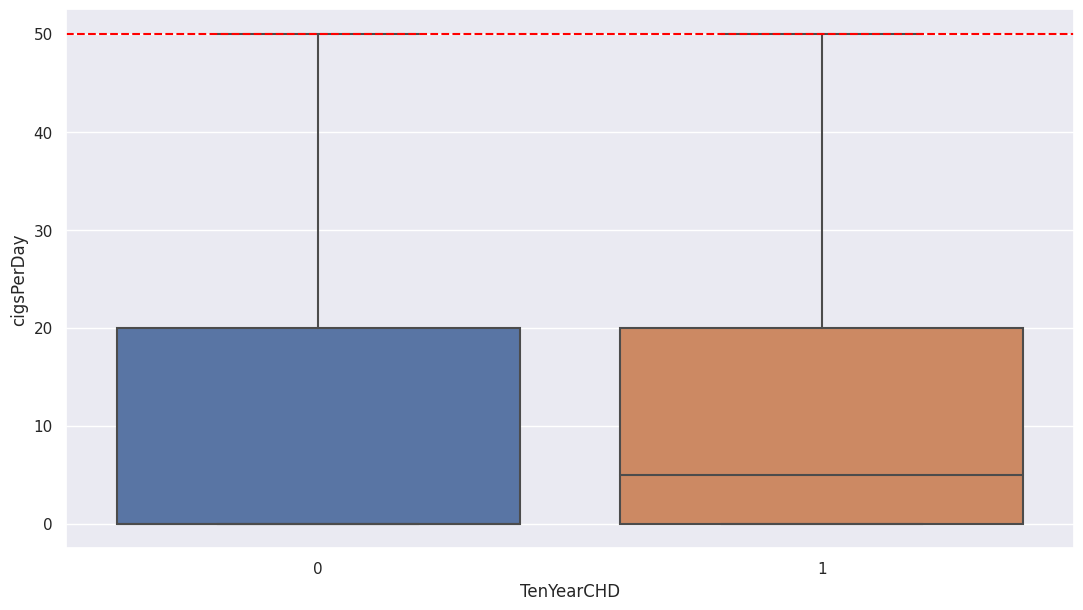

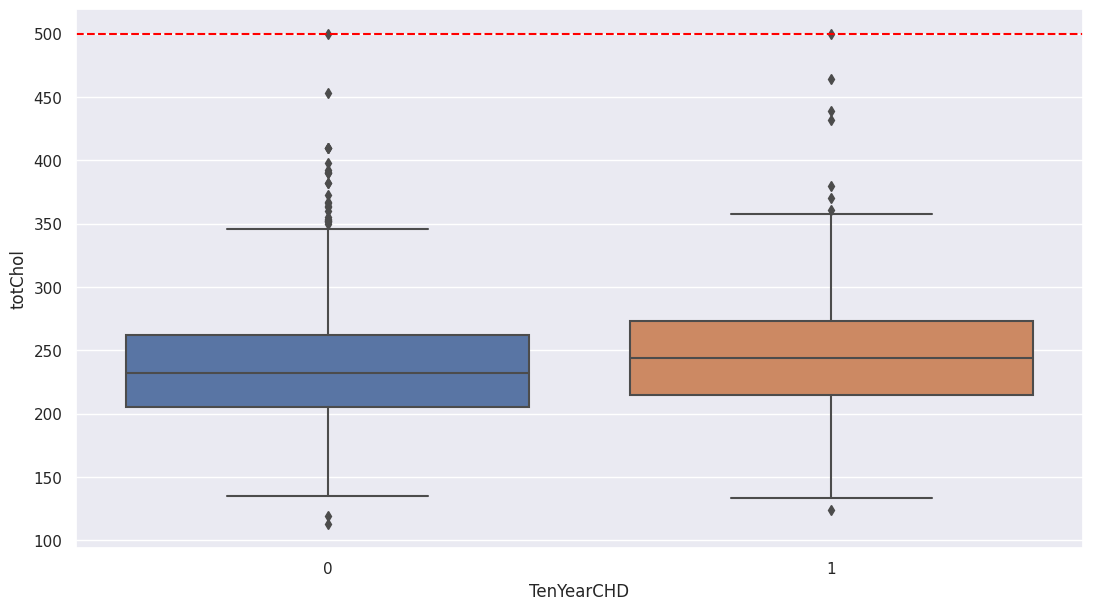

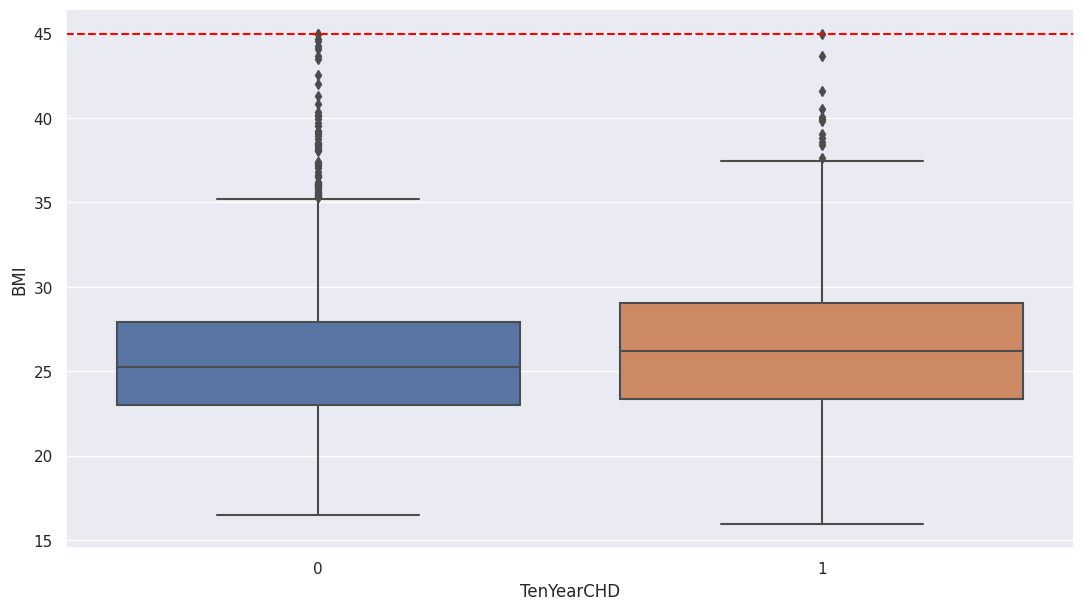

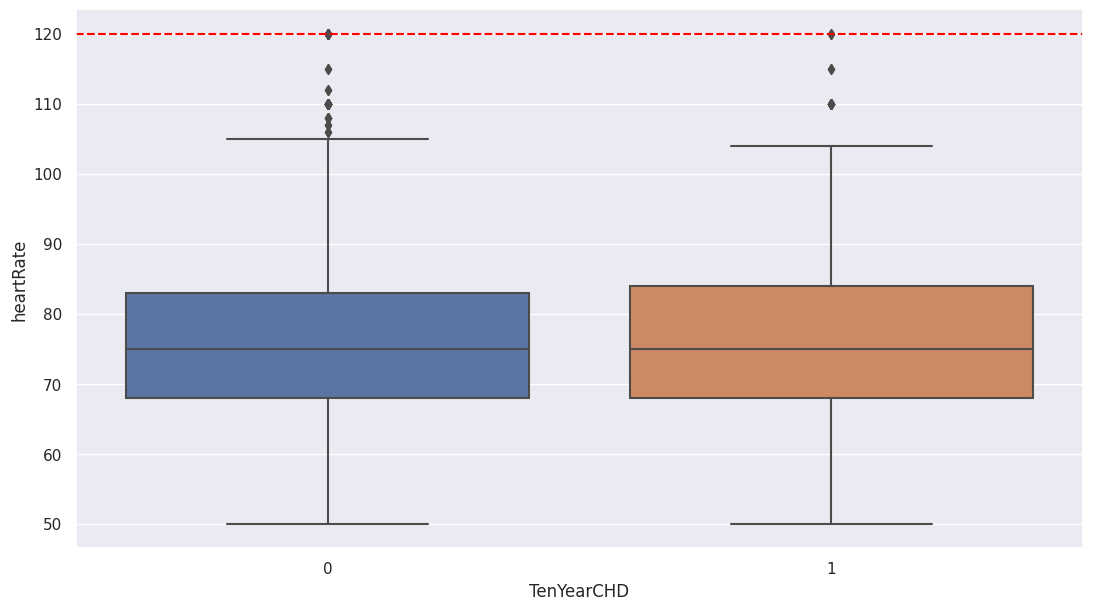

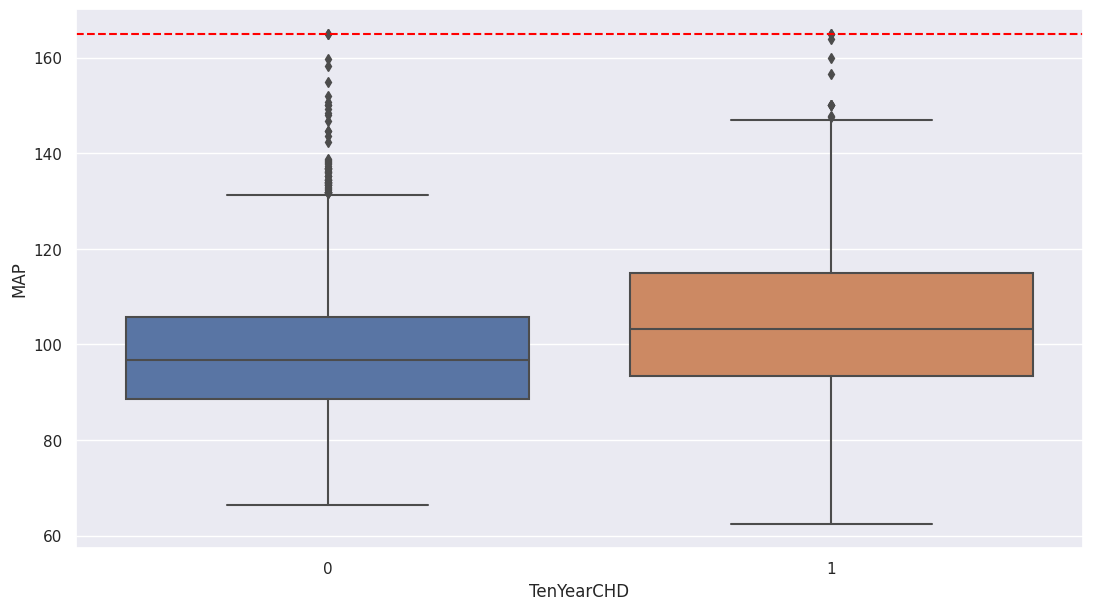

In [ ]:
# Visualising the outliers with the maximum limit after Winsorising
for var, limit in zip(outlier_vars, max_limits):
  plt.figure(figsize = (13,7))
  sns.boxplot(data = data, y = var, x = 'TenYearCHD')
  plt.axhline(limit, color = 'red', linestyle = '--')
  plt.ylabel(var)
  plt.show()

All the datapoints for each variable have now been contained within the chosen limits

### 4. Categorical Encoding

In [ ]:
# Encoding sex column
data['sex'] = data['sex'].map({'M':1, 'F':0})

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3004 entries, 1 to 3389
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3004 non-null   int64  
 1   age             3004 non-null   int64  
 2   sex             3004 non-null   int64  
 3   cigsPerDay      3004 non-null   float64
 4   BPMeds          3004 non-null   float64
 5   totChol         3004 non-null   float64
 6   BMI             3004 non-null   float64
 7   heartRate       3004 non-null   float64
 8   TenYearCHD      3004 non-null   int64  
 9   MAP             3004 non-null   float64
 10  diabetes_grade  3004 non-null   int64  
dtypes: float64(6), int64(5)
memory usage: 281.6 KB


All variables are now in numerical datatype

#### What all categorical encoding techniques have you used & why did you use those techniques?

One-Hot Encoding was used here since the sex variable had only 2 classes. Essentially, what this feature represents is whether a patient is male or not by assigning a non-zero value if it is male.

### 5. Data Splitting

In [ ]:
X = data.drop(['TenYearCHD', 'id'], axis = 1)
Y = data['TenYearCHD']

# Visualising the input data
X.head()

,age,sex,cigsPerDay,BPMeds,totChol,BMI,heartRate,MAP,diabetes_grade
1,36,1,0.0,0.0,212.0,29.77,72.0,121.333333,2
2,46,0,10.0,0.0,250.0,20.35,88.0,86.000000,2
3,50,1,20.0,0.0,233.0,28.26,68.0,111.333333,2
4,64,0,30.0,0.0,241.0,26.42,70.0,102.166667,2
5,61,0,0.0,0.0,272.0,32.80,85.0,141.333333,1


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 8, stratify = Y, shuffle = True)

### 6. Handling Imbalanced Dataset

In [ ]:
# Handling Imbalanced Dataset
smote = SMOTE(random_state = 8)
X_smote, Y_train_final = smote.fit_resample(X_train, Y_train)

Text(0.5, 0, 'TenYearCHD')

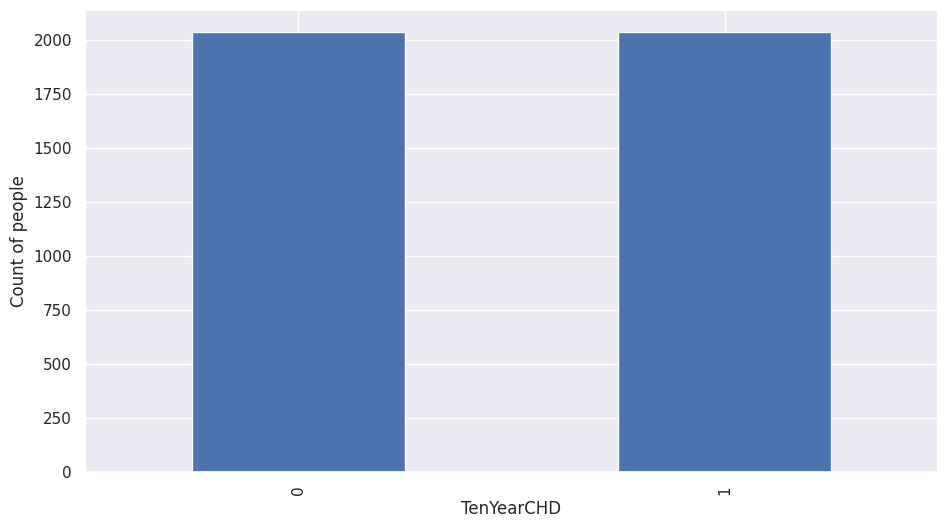

In [ ]:
# Visualising the class balance after using SMOTE
plt.figure(figsize = (11, 6))
ax = Y_train_final.value_counts().plot(kind = 'bar')
plt.ylabel('Count of people')
plt.xlabel('TenYearCHD')

### 7. Data Scaling

In [ ]:
# Scaling the train and test data according to train data
scaler = MinMaxScaler()
X_train_final = scaler.fit_transform(X_smote)
X_test_final = scaler.transform(X_test)

## **4. ML Model Implementation**

The following 7 models are implemented in this section on the train dataset, and then tested on the test data.
*   Logistic Regression
*   Naive Bayes
*   Decision Tree
*   KNN
*   Support Vector Machine
*   Random Forest
*   XGBoost

The models are implemented on a rough order of descending explainability and ascending complexity. Usually, for a case as intricate as a heart disease prediction, the models should be more interpretable/explainable. 

The scoring metric preferred for evaluation is the **Recall**, which is defined as below

\begin{align}
Recall = \frac{TruePositive} {True Positive + False Negative}
\end{align}

where **True Positive** is the number of correctly predicted patients with CVD risk, while **False Negative** is the number of patients who have a risk of CVD but were wrongly predicted to not have any.

Apart from Recall, the **ROC-AUC score** is also recorded for each model.


### Functions to train each ML Model

In [ ]:
# Function to plot the Confusion Matrix
def confusion_plot(cm):
  '''Plots the Confusion Matrix given as input'''
  cmd = ConfusionMatrixDisplay(cm, display_labels = ['No risk (0)', 'Risk (1)'])
  cmd.plot(cmap = 'Blues')
  plt.title('Confusion Matrix for Test Data')
  plt.show()

# Function to train and test a given classification model
def model_train_test(model, train_x, train_y, test_x, test_y, gs = False, confusion = True):
  '''Trains the classification model given as input. Other inputs include Test and train data
  and a Boolean to inform the function if GridSearch is being performed
  Returns the train and test Recalls and ROC-AUC scores, the test data predictions, and the final model'''
  
  model.fit(train_x, train_y)
  if gs == True:
    print(f'Best model parameters are: {model.best_params_}')
    print(f'Best model score is: {model.best_score_}\n')
    model = model.best_estimator_
  
  # Getting the train and test predictions
  train_preds = model.predict(train_x)
  train_recall = recall_score(y_true = train_y, y_pred = train_preds, average='binary')
  train_roc = roc_auc_score(train_y, train_preds)
  test_preds = model.predict(test_x)
  test_recall = recall_score(y_true = test_y, y_pred = test_preds, average='binary')
  test_roc = roc_auc_score(test_y, test_preds)
  
  # Plotting confusion matrix
  if confusion == True:
    confusion_plot(confusion_matrix(test_y, test_preds))

  output_metrics = {'Train Recall':train_recall, 'Test Recall':test_recall, 'Train ROC-AUC':train_roc, 'Test ROC-AUC':test_roc}
  return output_metrics, test_preds, model

In [ ]:
# Creating a dictionary of lists to store Train and test Recalls and ROC-AUC scores
scores = dict()
scores['Train Recall'] = []
scores['Test Recall'] = []
scores['Train ROC-AUC'] = []
scores['Test ROC-AUC'] = []
model_names = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'KNN', 'SVM', 'Random Forest', 'XGBoost']

### ML Model - 1 - Logistic Regression

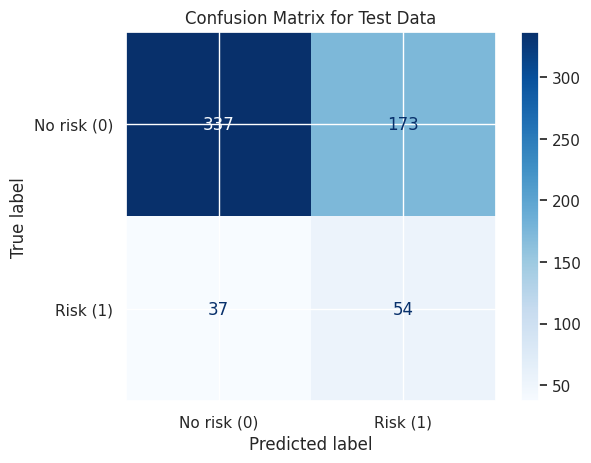

In [ ]:
lr_scores, lr_test_preds, lr_model = model_train_test(LogisticRegression(), X_train_final, Y_train_final, X_test_final, Y_test)

In [ ]:
print(classification_report(Y_test, lr_test_preds, target_names=['class-0', 'class-1']))

              precision    recall  f1-score   support

     class-0       0.90      0.66      0.76       510
     class-1       0.24      0.59      0.34        91

    accuracy                           0.65       601
   macro avg       0.57      0.63      0.55       601
weighted avg       0.80      0.65      0.70       601



In [ ]:
def print_scores(model_name, model_scores):
  '''Function to print the scores of a given model'''
  print(f"The train and test recalls of the {model_name} Model are: {round(model_scores['Train Recall'] * 100, 2)}% and {round(model_scores['Test Recall'] * 100, 2)}% respectively")
  print(f"The train and test ROC-AUC scores of the {model_name} Model are: {round(model_scores['Train ROC-AUC'] * 100, 2)}% and {round(model_scores['Test ROC-AUC'] * 100, 2)}% respectively")

print_scores(model_name = model_names[0], model_scores = lr_scores)

The train and test recalls of the Logistic Regression Model are: 70.25% and 59.34% respectively
The train and test ROC-AUC scores of the Logistic Regression Model are: 68.21% and 62.71% respectively


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'Feature importances')]

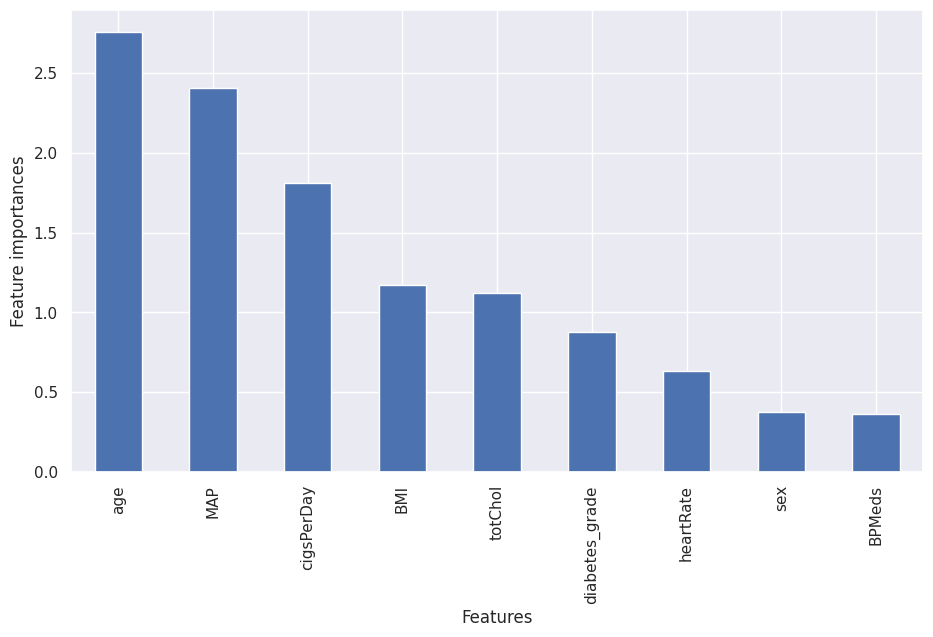

In [ ]:
lr_importances = pd.Series(abs(lr_model.coef_[0]), index = X.columns)
plt.figure(figsize = (11, 6))
ax = lr_importances.sort_values(ascending = False).plot(kind = 'bar')
ax.set(xlabel = 'Features', ylabel = 'Feature importances')

In [ ]:
for score in lr_scores:
  scores[score].append(lr_scores[score] * 100)

### ML Model - 2 - Naive Bayes

In [ ]:
params_nb = {'var_smoothing': np.logspace(0, -9, num = 50)}
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
scorer = make_scorer(recall_score, average = 'binary')

nb_models = GridSearchCV(GaussianNB(), params_nb, cv = cv, scoring = scorer)

Best model parameters are: {'var_smoothing': 1.0}
Best model score is: 0.532972812384577



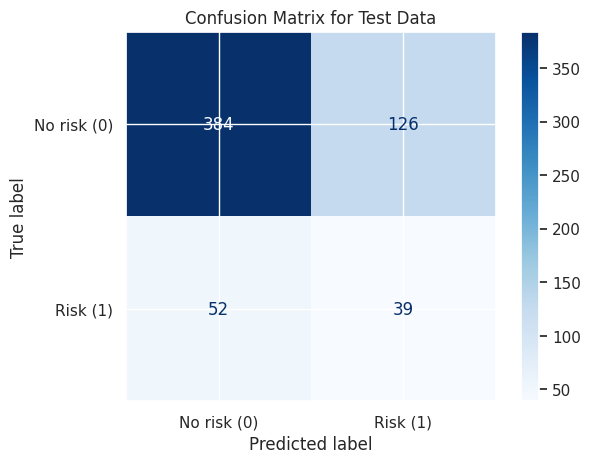

In [ ]:
nb_scores, nb_test_preds, nb_model = model_train_test(nb_models, X_train_final, Y_train_final, X_test_final, Y_test, gs = True)

In [ ]:
print(classification_report(Y_test, nb_test_preds, target_names=['class-0', 'class-1']))

              precision    recall  f1-score   support

     class-0       0.88      0.75      0.81       510
     class-1       0.24      0.43      0.30        91

    accuracy                           0.70       601
   macro avg       0.56      0.59      0.56       601
weighted avg       0.78      0.70      0.74       601



In [ ]:
print_scores(model_name = model_names[1], model_scores = nb_scores)

The train and test recalls of the Naive Bayes Model are: 53.36% and 42.86% respectively
The train and test ROC-AUC scores of the Naive Bayes Model are: 64.58% and 59.08% respectively


In [ ]:
for score in nb_scores:
  scores[score].append(nb_scores[score] * 100)

### ML Model - 3 - Decision Tree

In [ ]:
params_dt = {
              'max_depth' : [3, 4, 5],
              'min_samples_split':[10, 20, 25, 30],
              'min_samples_leaf':[10, 20, 25, 30]
              }

dt_model = DecisionTreeClassifier(criterion= 'entropy', random_state = 42)
dt_models = GridSearchCV(dt_model, params_dt, cv = cv, scoring = scorer)

Best model parameters are: {'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 10}
Best model score is: 0.7871167959403255



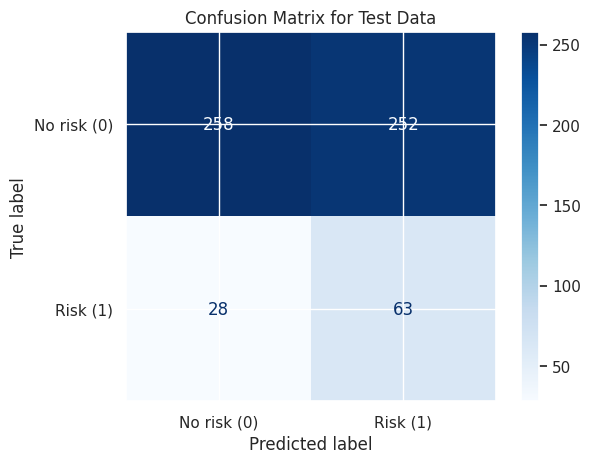

CPU times: user 8.45 s, sys: 82.3 ms, total: 8.53 s
Wall time: 8.48 s


In [ ]:
%%time
dt_scores, dt_test_preds, dt_model = model_train_test(dt_models, X_train_final, Y_train_final, X_test_final, Y_test, gs = True)

In [ ]:
print(classification_report(Y_test, dt_test_preds, target_names=['class-0', 'class-1']))

              precision    recall  f1-score   support

     class-0       0.90      0.51      0.65       510
     class-1       0.20      0.69      0.31        91

    accuracy                           0.53       601
   macro avg       0.55      0.60      0.48       601
weighted avg       0.80      0.53      0.60       601



In [ ]:
print_scores(model_name = model_names[2], model_scores = dt_scores)

The train and test recalls of the Decision Tree Model are: 81.59% and 69.23% respectively
The train and test ROC-AUC scores of the Decision Tree Model are: 68.78% and 59.91% respectively


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'Feature importances')]

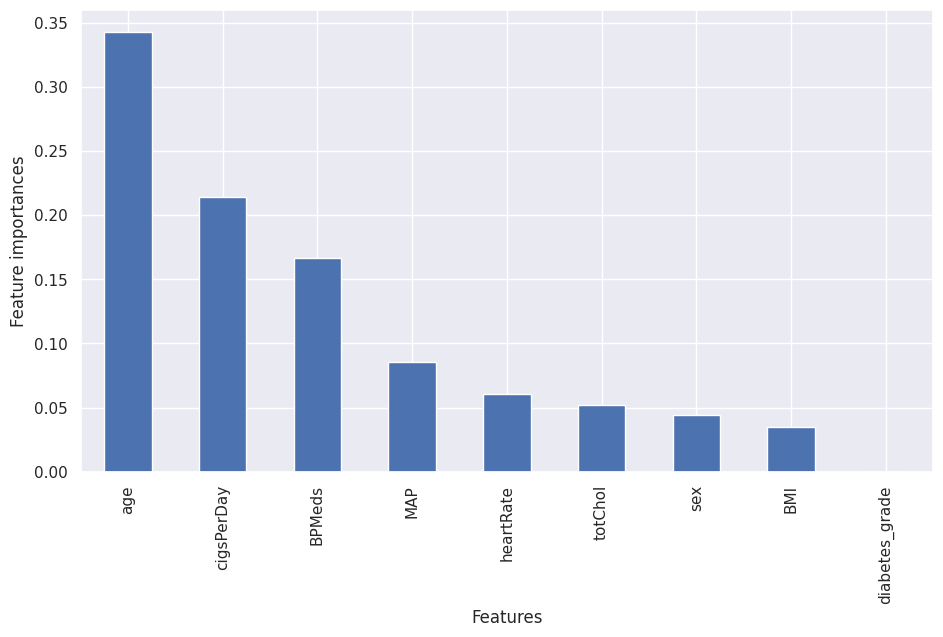

In [ ]:
dt_importances = pd.Series(dt_model.feature_importances_, index = X.columns)
plt.figure(figsize = (11, 6))
ax = dt_importances.sort_values(ascending = False).plot(kind = 'bar')
ax.set(xlabel = 'Features', ylabel = 'Feature importances')

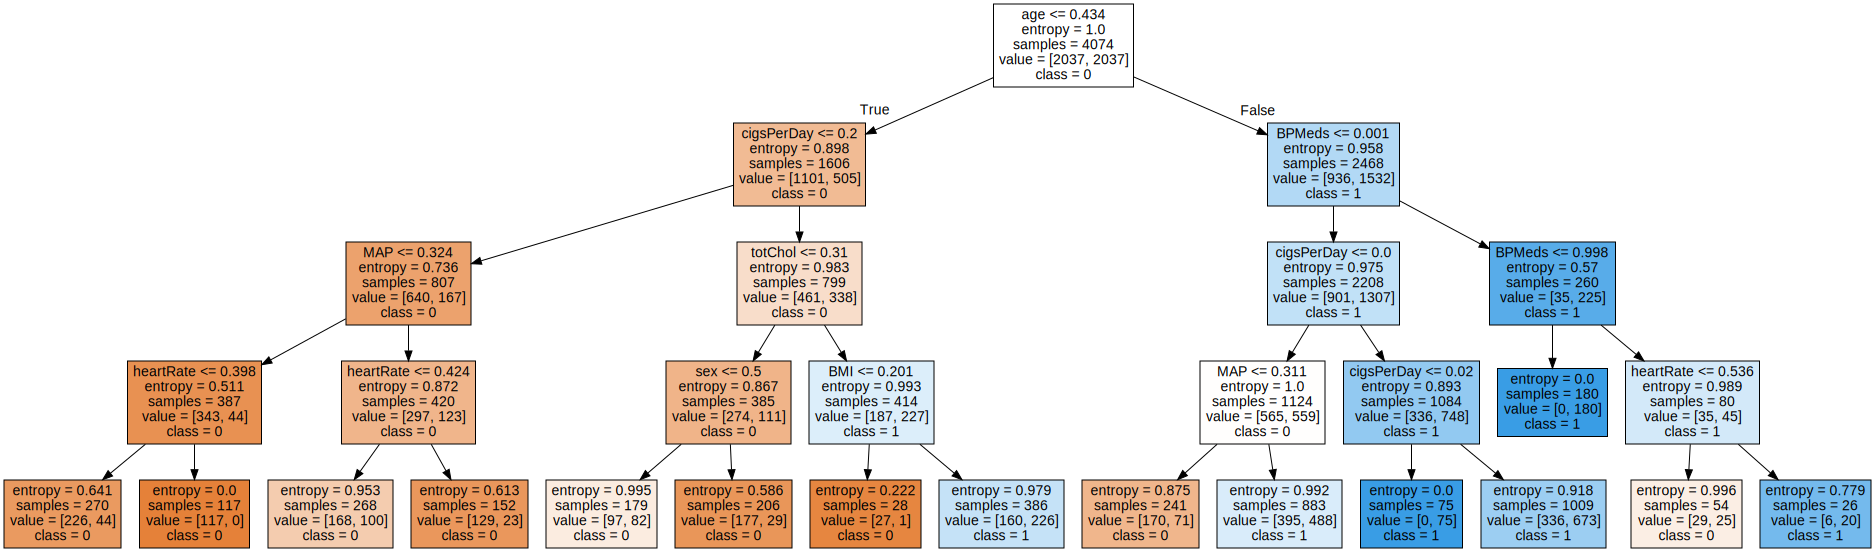

In [ ]:
# Visualising the decision tree
graph = Source(tree.export_graphviz(dt_model, out_file = None, feature_names = X.columns, class_names=['0', '1'] , filled = True))
display(SVG(graph.pipe(format = 'svg')))

In [ ]:
for score in dt_scores:
  scores[score].append(dt_scores[score] * 100)

### ML Model - 4 - K-Nearest Neighbours

In [ ]:
# Fitting the knn model for various values of k
%%time
knn_train_recalls = []
knn_test_recalls = []
for k in range(1, 51):
  knn_scores = model_train_test(KNeighborsClassifier(n_neighbors = k), X_train_final, Y_train_final, X_test_final, Y_test, confusion = False)[0]
  knn_train_recalls.append(knn_scores['Train Recall'])
  knn_test_recalls.append(knn_scores['Test Recall'])

CPU times: user 14.3 s, sys: 175 ms, total: 14.5 s
Wall time: 14.4 s


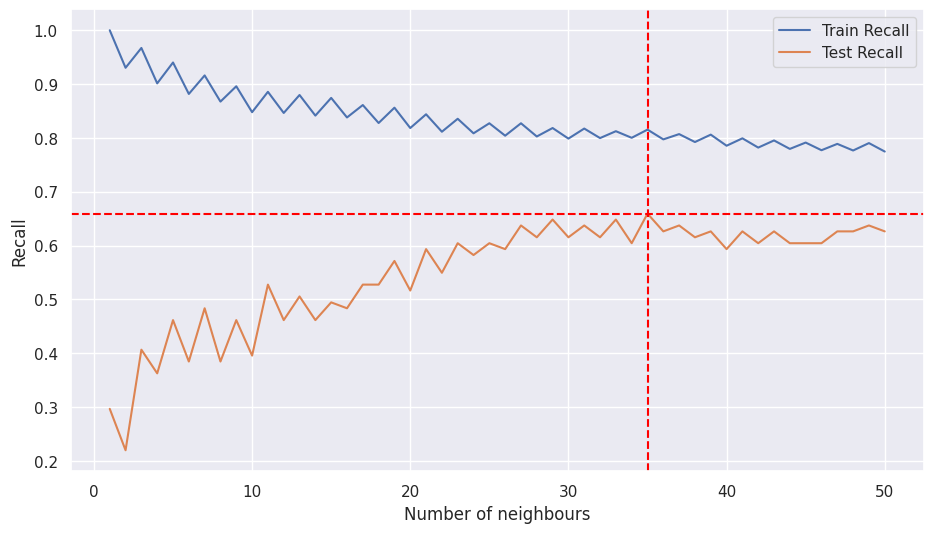

Optimum value of n_neighbours with highest value of test recall is 35


In [ ]:
# Plotting the train and test recalls
k_optimum = knn_test_recalls.index(max(knn_test_recalls)) + 1
plt.figure(figsize=(11, 6))
plt.plot(range(1, 51), knn_train_recalls, label='Train Recall')
plt.plot(range(1, 51), knn_test_recalls, label='Test Recall')
plt.axhline(max(knn_test_recalls), color = 'red', linestyle = '--')
plt.axvline(k_optimum, color = 'red', linestyle = '--')
plt.xlabel('Number of neighbours')
plt.ylabel('Recall')
plt.legend()
plt.show()

print(f'Optimum value of n_neighbours with highest value of test recall is {k_optimum}')

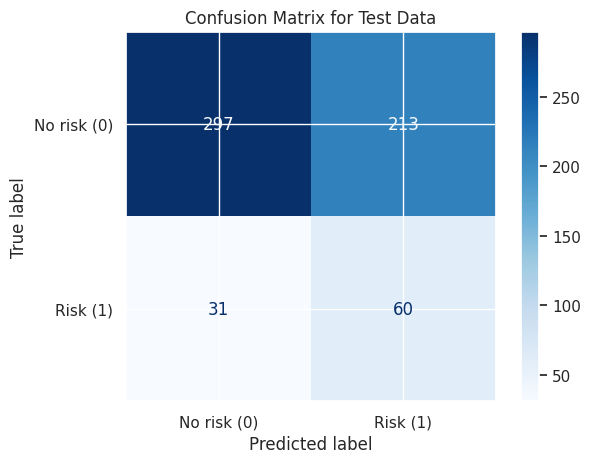

In [ ]:
# Fitting the knn model with the optimum k
knn_scores, knn_test_preds, knn_model = model_train_test(KNeighborsClassifier(n_neighbors = k_optimum), X_train_final, Y_train_final, X_test_final, Y_test, gs = False)

In [ ]:
print(classification_report(Y_test, knn_test_preds, target_names=['class-0', 'class-1']))

              precision    recall  f1-score   support

     class-0       0.91      0.58      0.71       510
     class-1       0.22      0.66      0.33        91

    accuracy                           0.59       601
   macro avg       0.56      0.62      0.52       601
weighted avg       0.80      0.59      0.65       601



In [ ]:
print_scores(model_name = model_names[3], model_scores = knn_scores)

The train and test recalls of the KNN Model are: 81.54% and 65.93% respectively
The train and test ROC-AUC scores of the KNN Model are: 71.67% and 62.08% respectively


In [ ]:
for score in knn_scores:
  scores[score].append(knn_scores[score] * 100)

### ML Model - 5 - Support Vector Machine

In [ ]:
params_svc = {
              'C':[0.1, 1, 10],
              'gamma':[0.01, 0.001, 0.0001],
              'kernel':['rbf', 'poly', 'sigmoid']
              }

svc_models = GridSearchCV(SVC(), params_svc, cv = cv, scoring = scorer)

Best model parameters are: {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}
Best model score is: 0.7344124873536638



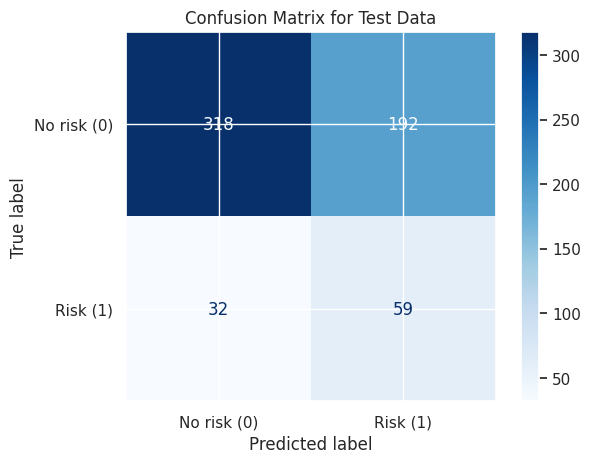

CPU times: user 3min 24s, sys: 4.83 s, total: 3min 29s
Wall time: 3min 34s


In [ ]:
%%time
svc_scores, svc_test_preds, svc_model = model_train_test(svc_models, X_train_final, Y_train_final, X_test_final, Y_test, gs = True)

In [ ]:
print(classification_report(Y_test, svc_test_preds, target_names=['class-0', 'class-1']))

              precision    recall  f1-score   support

     class-0       0.91      0.62      0.74       510
     class-1       0.24      0.65      0.35        91

    accuracy                           0.63       601
   macro avg       0.57      0.64      0.54       601
weighted avg       0.81      0.63      0.68       601



In [ ]:
print_scores(model_name = model_names[4], model_scores = svc_scores)

The train and test recalls of the SVM Model are: 73.49% and 64.84% respectively
The train and test ROC-AUC scores of the SVM Model are: 68.21% and 63.59% respectively


In [ ]:
for score in svc_scores:
  scores[score].append(svc_scores[score] * 100)

### ML Model - 6 - Random Forest

In [ ]:
params_rf = {
              'n_estimators':[50, 100, 200],
              'max_depth':[3, 4, 5],
              'min_samples_split':[10, 20, 25],
              'min_samples_leaf':[10, 20, 25]
              }

rf_model = RandomForestClassifier(criterion= 'entropy', random_state = 42)
rf_models = GridSearchCV(rf_model, params_rf, cv = cv, scoring = scorer)

Best model parameters are: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best model score is: 0.7484852499558382



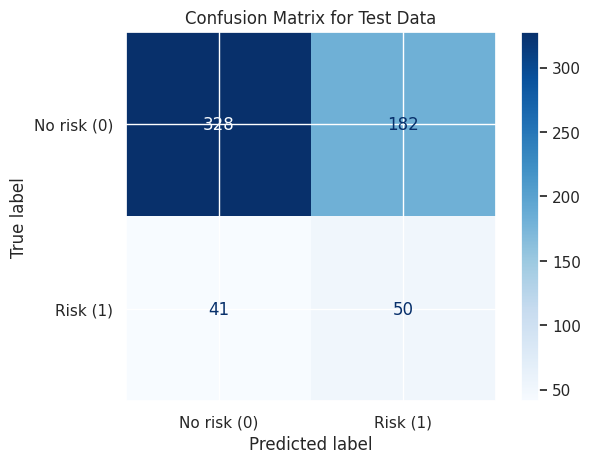

CPU times: user 8min 11s, sys: 1.56 s, total: 8min 12s
Wall time: 8min 16s


In [ ]:
%%time
rf_scores, rf_test_preds, rf_model = model_train_test(rf_models, X_train_final, Y_train_final, X_test_final, Y_test, gs = True)

In [ ]:
print(classification_report(Y_test, rf_test_preds, target_names=['class-0', 'class-1']))

              precision    recall  f1-score   support

     class-0       0.89      0.64      0.75       510
     class-1       0.22      0.55      0.31        91

    accuracy                           0.63       601
   macro avg       0.55      0.60      0.53       601
weighted avg       0.79      0.63      0.68       601



In [ ]:
print_scores(model_name = model_names[5], model_scores = rf_scores)

The train and test recalls of the Random Forest Model are: 77.37% and 54.95% respectively
The train and test ROC-AUC scores of the Random Forest Model are: 73.49% and 59.63% respectively


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'Feature importances')]

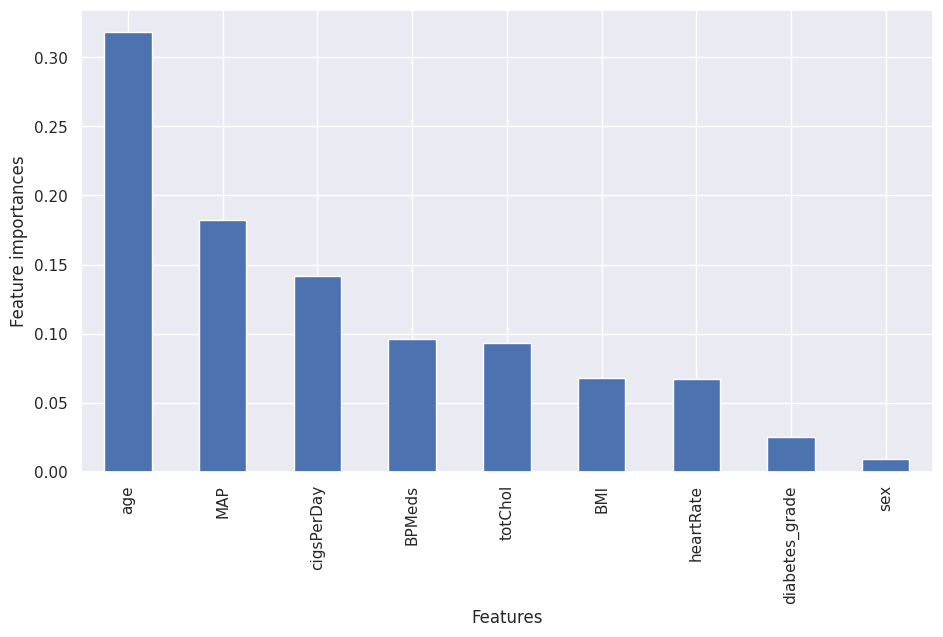

In [ ]:
rf_importances = pd.Series(rf_model.feature_importances_, index = X.columns)
plt.figure(figsize = (11, 6))
ax = rf_importances.sort_values(ascending = False).plot(kind = 'bar')
ax.set(xlabel = 'Features', ylabel = 'Feature importances')

In [ ]:
for score in rf_scores:
  scores[score].append(rf_scores[score] * 100)

### ML Model - 7 - XGBoost

In [ ]:
params_xgb = {
              'n_estimators':[50, 100],
              'max_depth':[3, 4],
              'learning_rate':[0.01, 0.02]
              }

xgb_model = xgb.XGBClassifier(random_state = 42)
xgb_models = GridSearchCV(xgb_model, params_xgb, cv = cv, scoring = scorer)

Best model parameters are: {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 100}
Best model score is: 0.7727092065327359



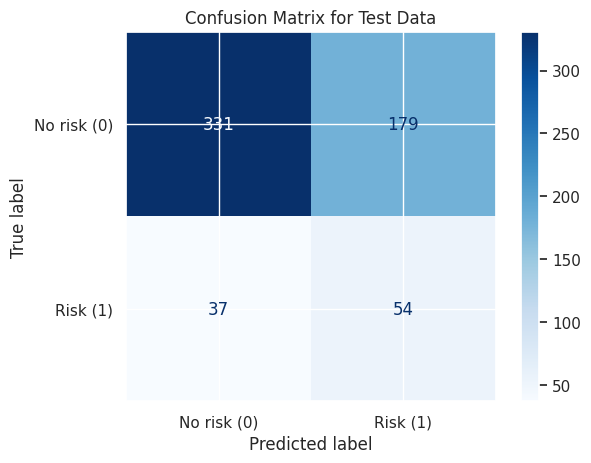

CPU times: user 38.4 s, sys: 425 ms, total: 38.9 s
Wall time: 23.2 s


In [ ]:
%%time
xgb_scores, xgb_test_preds, xgb_model = model_train_test(xgb_models, X_train_final, Y_train_final, X_test_final, Y_test, gs = True)

In [ ]:
print(classification_report(Y_test, xgb_test_preds, target_names=['class-0', 'class-1']))

              precision    recall  f1-score   support

     class-0       0.90      0.65      0.75       510
     class-1       0.23      0.59      0.33        91

    accuracy                           0.64       601
   macro avg       0.57      0.62      0.54       601
weighted avg       0.80      0.64      0.69       601



In [ ]:
print_scores(model_name = model_names[6], model_scores = xgb_scores)

The train and test recalls of the XGBoost Model are: 80.02% and 59.34% respectively
The train and test ROC-AUC scores of the XGBoost Model are: 74.99% and 62.12% respectively


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'Feature importances')]

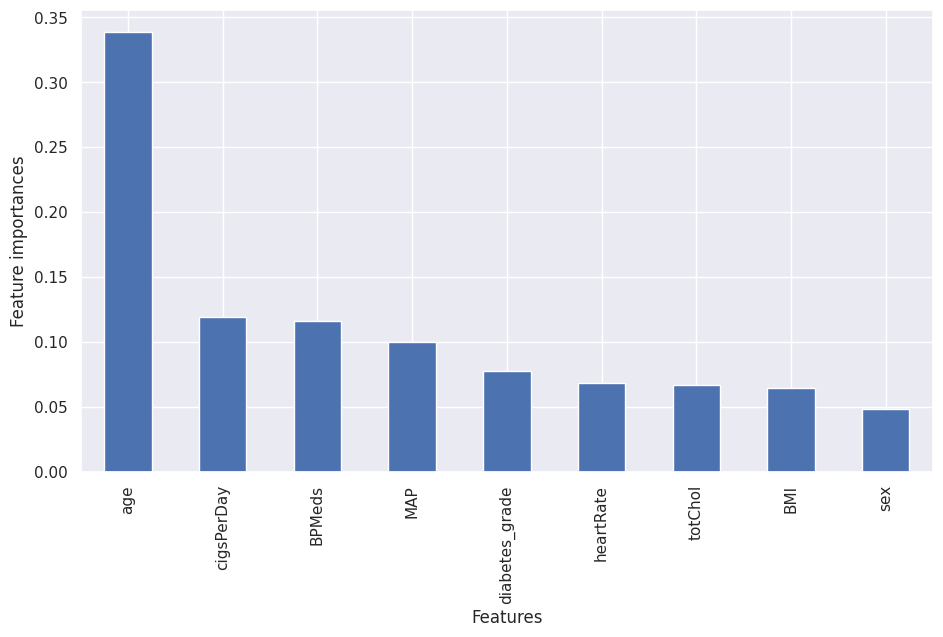

In [ ]:
xgb_importances = pd.Series(xgb_model.feature_importances_, index = X.columns)
plt.figure(figsize = (11, 6))
ax = xgb_importances.sort_values(ascending = False).plot(kind = 'bar')
ax.set(xlabel = 'Features', ylabel = 'Feature importances')

In [ ]:
for score in xgb_scores:
  scores[score].append(xgb_scores[score] * 100)

### 1. Which ML model did you choose from the above created models as your final prediction model and why?

In [ ]:
results_df = pd.DataFrame(scores, index = model_names)
styler_list = [
                {'selector': 'th','props': [('border', '2px solid black')]},
                {'selector': 'td','props': [('border', '2px solid black')]}
              ]
styler = results_df.style.set_table_styles(styler_list)
display(styler)

,Train Recall,Test Recall,Train ROC-AUC,Test ROC-AUC
Logistic Regression,70.250368,59.340659,68.213058,62.709545
Naive Bayes,53.362788,42.857143,64.580265,59.075630
Decision Tree,81.590574,69.230769,68.777614,59.909502
KNN,81.541483,65.934066,71.674030,62.084680
SVM,73.490427,64.835165,68.213058,63.594053
Random Forest,77.368679,54.945055,73.490427,59.629390
XGBoost,80.019637,59.340659,74.987727,62.121310


In [ ]:
# results_df.to_csv('/content/drive/MyDrive/ALMA BETTER/Module 4/#CAPSTONE 2 - CLASSIFICATION/Outputs/results_df_dropna', index = False)

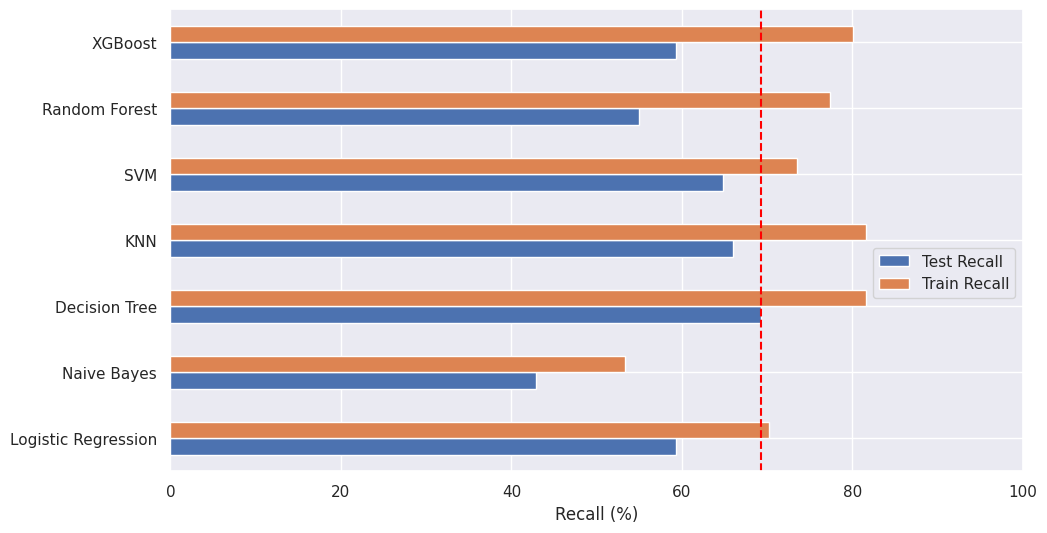

In [ ]:
results_df[['Test Recall', 'Train Recall']].plot(kind = 'barh', figsize = (11, 6))
plt.xlabel('Recall (%)')
plt.xlim((0, 100))
plt.axvline(results_df['Test Recall'].max(), color = 'red', linestyle = '--')
plt.legend(bbox_to_anchor = (1, 0.5))
plt.show()